In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.integrate import solve_ivp
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna
import pysindy as ps
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from optuna.trial import TrialState

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define double pendulum dynamics
def double_pendulum(t, y, l1, l2, m1, m2, g):
    theta1, z1, theta2, z2 = y
    delta = theta2 - theta1
    denom1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta) ** 2
    denom2 = (l2 / l1) * denom1

    dydt = np.zeros_like(y)
    dydt[0] = z1
    dydt[1] = (
        (m2 * l1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
         + m2 * g * np.sin(theta2) * np.cos(delta)
         + m2 * l2 * z2 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta1))
        / denom1
    )
    dydt[2] = z2
    dydt[3] = (
        (-m2 * l2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
         + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
         - (m1 + m2) * l1 * z1 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta2))
        / denom2
    )
    return dydt

In [3]:
n_pendulums = 2000  # data set sizae
data = []

In [4]:
# Generate dataset with second derivatives
for _ in range(n_pendulums):
    l1, l2 = np.random.uniform(0.5, 2.0, 2)
    m1, m2 = np.random.uniform(0.5, 2.0, 2)
    g = 9.81
    y0 = np.random.uniform(-np.pi, np.pi, 4)
    t_span = (0, 10)
    t_eval = np.linspace(t_span[0], t_span[1], 200)  # Finer temporal resolution
    sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, args=(l1, l2, m1, m2, g))
    
    theta1, theta1_dot, theta2, theta2_dot = sol.y
    theta1_ddot = np.gradient(theta1_dot, t_eval)
    theta2_ddot = np.gradient(theta2_dot, t_eval)
    
    X = np.vstack([theta1, theta2, theta1_dot, theta2_dot]).T  # Inputs: angles and angular velocities
    y = np.vstack([theta1_ddot, theta2_ddot]).T               # Targets: angular accelerations
    data.append((X, y, l1, l2, m1, m2, g))



MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


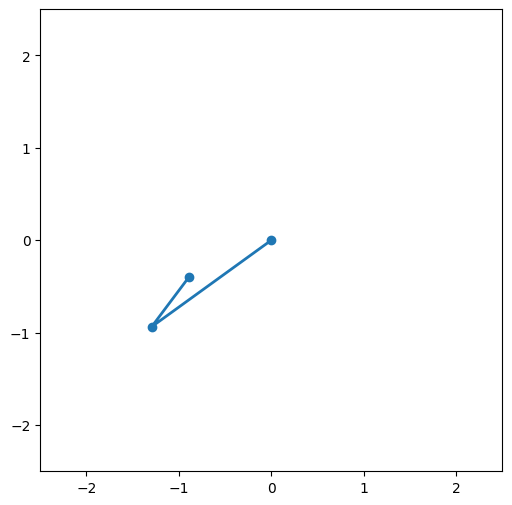

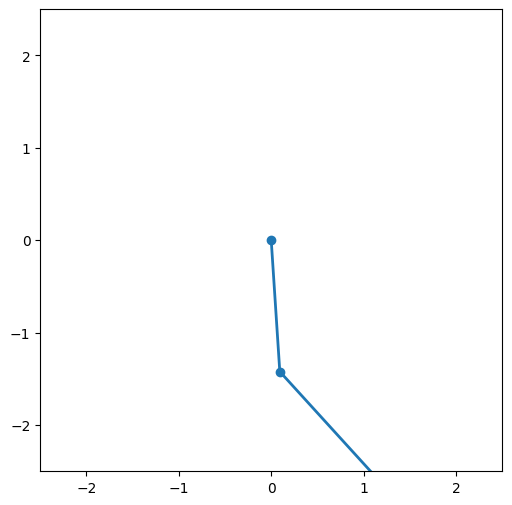

In [5]:
def visualize_double_pendulum(example, save_path=None):
    X, _, l1, l2, _, _, _ = example  # Skip 'y'
    theta1, theta2 = X[:, 0], X[:, 1]

    # Compute positions
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    line, = ax.plot([], [], 'o-', lw=2)

    def update(frame):
        line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
        return line,

    ani = FuncAnimation(fig, update, frames=len(theta1), blit=True, interval=50)

    if save_path:
        ani.save(save_path, fps=20, writer='imagemagick')
    else:
        plt.show()

# Visualize two examples
visualize_double_pendulum(data[0], save_path='double_pendulum1.gif')
visualize_double_pendulum(data[1], save_path='double_pendulum2.gif')

In [77]:
# Split dataset
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train = np.vstack([example[0] for example in train_data])
scaler.fit(X_train)

train_data = [(scaler.transform(example[0]), *example[1:]) for example in train_data]
val_data = [(scaler.transform(example[0]), *example[1:]) for example in val_data]
test_data = [(scaler.transform(example[0]), *example[1:]) for example in test_data]

In [78]:
# Save data
with open('extended_double_pendulum_dataset.pkl', 'wb') as f:
    pickle.dump({'train': train_data, 'val': val_data, 'test': test_data}, f)

In [94]:
class PINN(nn.Module):
    def __init__(self, layers, dropout_rate=0.2):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(layers[0], layers[1])
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(layers) - 2):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(layers[i], layers[i + 1]),
                nn.BatchNorm1d(layers[i + 1]),
                nn.SiLU(),
                nn.Dropout(dropout_rate)
            ))
        self.output_layer = nn.Linear(layers[-2], layers[-1])

    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

In [95]:
# Define custom loss functions
def log_cosh_loss(y_pred, y_true):
    diff = y_pred - y_true
    return torch.mean(torch.log(torch.cosh(diff)))


In [96]:
def physics_loss(y_pred, y_true, params_batch, X_batch):
    l1, l2, m1, m2, g = params_batch
    theta1, theta2, theta1_dot, theta2_dot = torch.split(X_batch, 1, dim=1)
    theta1_ddot, theta2_ddot = torch.split(y_pred, 1, dim=1)

    delta = theta2 - theta1
    physics_term1 = (
        (m2 * l1 * theta1_dot**2 * torch.sin(delta) * torch.cos(delta)
         + m2 * g * torch.sin(theta2) * torch.cos(delta)
         + m2 * l2 * theta2_dot**2 * torch.sin(delta)
         - (m1 + m2) * g * torch.sin(theta1))
        / ((m1 + m2) * l1 - m2 * l1 * torch.cos(delta)**2)
    )
    physics_term2 = (
        (-m2 * l2 * theta2_dot**2 * torch.sin(delta) * torch.cos(delta)
         + (m1 + m2) * g * torch.sin(theta1) * torch.cos(delta)
         - (m1 + m2) * l1 * theta1_dot**2 * torch.sin(delta)
         - (m1 + m2) * g * torch.sin(theta2))
        / ((l2 / l1) * ((m1 + m2) * l1 - m2 * l1 * torch.cos(delta)**2))
    )

    loss = torch.mean((theta1_ddot - physics_term1)**2 + (theta2_ddot - physics_term2)**2)
    return loss

In [97]:
# Load data
with open('extended_double_pendulum_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_data = dataset['train']
val_data = dataset['val']
test_data = dataset['test']

In [99]:
# Prepare data
X_train = torch.tensor(np.vstack([example[0] for example in train_data]), dtype=torch.float32)
y_train = torch.tensor(np.vstack([example[1] for example in train_data]), dtype=torch.float32)
params_train = torch.tensor([example[2:] for example in train_data], dtype=torch.float32)

X_val = torch.tensor(np.vstack([example[0] for example in val_data]), dtype=torch.float32)
y_val = torch.tensor(np.vstack([example[1] for example in val_data]), dtype=torch.float32)
params_val = torch.tensor([example[2:] for example in val_data], dtype=torch.float32)

In [100]:
# Train PINN
model = PINN([4, 256, 256, 128, 64, 2])  # Increased depth and residual connections
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

criterion = nn.MSELoss()
epochs = 100
early_stopping_patience = 10
best_val_loss = float('inf')
best_model = None
patience_counter = 0

In [102]:
# Define accuracy metric for regression
def compute_accuracy(y_pred, y_true, threshold=0.1):
    # Calculate absolute error
    error = torch.abs(y_pred - y_true)
    # Count predictions within the threshold
    within_threshold = (error < threshold).all(dim=1).float()
    # Calculate percentage
    accuracy = within_threshold.mean().item() * 100
    return accuracy

In [103]:
# Start training
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train) + 0.1 * physics_loss(y_pred, y_train, params_train.T, X_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_accuracy = compute_accuracy(y_val_pred, y_val)  # Calculate accuracy

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Update scheduler
    scheduler.step()

    # Print metrics
    train_accuracy = compute_accuracy(y_pred, y_train)  # Calculate training accuracy
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1, Loss: 330.0924987792969, Val Loss: 294.4075622558594, Train Accuracy: 0.00%, Val Accuracy: 0.00%
Epoch 2, Loss: 329.1801452636719, Val Loss: 294.2883605957031, Train Accuracy: 0.00%, Val Accuracy: 0.00%
Epoch 3, Loss: 328.6101989746094, Val Loss: 294.1498718261719, Train Accuracy: 0.01%, Val Accuracy: 0.01%
Epoch 4, Loss: 328.1043395996094, Val Loss: 293.9916076660156, Train Accuracy: 0.00%, Val Accuracy: 0.01%


KeyboardInterrupt: 

In [ ]:
# Test performance
model.load_state_dict(best_model)
model.eval()
test_data = torch.tensor(np.vstack([example[0] for example in test_data]), dtype=torch.float32)
y_test = test_data[:, 2:]
test_params = torch.tensor([example[1:] for example in test_data], dtype=torch.float32)

y_test_pred = model(test_data)
test_loss = criterion(y_test_pred, y_test)
print(f"Test Loss: {test_loss.item()}")

In [ ]:
def visualize_prediction(example, model, scaler, save_path=None):
    X, l1, l2, _, _, _ = example
    theta1, theta2 = X[:, 0], X[:, 1]

    # Predict using the model
    X_tensor = torch.tensor(scaler.transform(X), dtype=torch.float32)
    y_pred = model(X_tensor).detach().numpy()

    theta1_pred, theta2_pred = y_pred[:, 0], y_pred[:, 1]

    # Compute positions for ground truth
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)

    # Compute positions for predictions
    x1_pred = l1 * np.sin(theta1_pred)
    y1_pred = -l1 * np.cos(theta1_pred)
    x2_pred = x1_pred + l2 * np.sin(theta2_pred)
    y2_pred = y1_pred - l2 * np.cos(theta2_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    line_true, = ax.plot([], [], 'o-', lw=2, label='Ground Truth')
    line_pred, = ax.plot([], [], 'o--', lw=2, label='Prediction')
    ax.legend()

    def update(frame):
        line_true.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
        line_pred.set_data([0, x1_pred[frame], x2_pred[frame]], [0, y1_pred[frame], y2_pred[frame]])
        return line_true, line_pred

    ani = FuncAnimation(fig, update, frames=len(theta1), blit=True, interval=50)

    if save_path:
        ani.save(save_path, fps=20, writer='imagemagick')
    else:
        plt.show()

# Visualize prediction vs ground truth for two examples
visualize_prediction(test_data[0], model, scaler, save_path='prediction_vs_ground_truth1.gif')
visualize_prediction(test_data[1], model, scaler, save_path='prediction_vs_ground_truth2.gif')

In [ ]:
def train_sindy(X, t):
    # Use custom feature library for trigonometric functions
    library = ps.PolynomialLibrary(degree=3) + ps.TrigonometricLibrary([1, 2])

    # Use a lower threshold to capture more dynamics
    optimizer = ps.STLSQ(threshold=0.05)

    # Instantiate and fit SINDy model
    sindy_model = ps.SINDy(feature_library=library, optimizer=optimizer, differentiation_method=ps.FiniteDifference())
    sindy_model.fit(X, t=t)
    return sindy_model

# Prepare data for SINDy
X_sindy = np.vstack([example[0] for example in train_data])
t_sindy = np.linspace(0, 10, X_sindy.shape[0])

# Train SINDy model
sindy_model = train_sindy(X_sindy, t_sindy)

# Display discovered equations
sindy_model.print()

In [ ]:
# Visualize SINDy predictions vs ground truth
def visualize_sindy_prediction(example, sindy_model, scaler, save_path=None):
    X, l1, l2, _, _, _ = example
    theta1, theta2 = X[:, 0], X[:, 1]

    # Predict using the SINDy model
    X_scaled = scaler.transform(X)
    y_pred = sindy_model.simulate(X_scaled[0], t=np.linspace(0, 10, X.shape[0]))

    theta1_pred, theta2_pred = y_pred[:, 0], y_pred[:, 1]

    # Compute positions for ground truth
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)

    # Compute positions for SINDy predictions
    x1_pred = l1 * np.sin(theta1_pred)
    y1_pred = -l1 * np.cos(theta1_pred)
    x2_pred = x1_pred + l2 * np.sin(theta2_pred)
    y2_pred = y1_pred - l2 * np.cos(theta2_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    line_true, = ax.plot([], [], 'o-', lw=2, label='Ground Truth')
    line_pred, = ax.plot([], [], 'o--', lw=2, label='SINDy Prediction')
    ax.legend()

    def update(frame):
        line_true.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
        line_pred.set_data([0, x1_pred[frame], x2_pred[frame]], [0, y1_pred[frame], y2_pred[frame]])
        return line_true, line_pred

    ani = FuncAnimation(fig, update, frames=len(theta1), blit=True, interval=50)

    if save_path:
        ani.save(save_path, fps=20, writer='imagemagick')
    else:
        plt.show()

# Visualize SINDy prediction vs ground truth for two examples
visualize_sindy_prediction(test_data[0], sindy_model, scaler, save_path='sindy_vs_ground_truth1.gif')
visualize_sindy_prediction(test_data[1], sindy_model, scaler, save_path='sindy_vs_ground_truth2.gif')